In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import contextlib
import re

from pmdarima import ARIMA
from pmdarima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel

from prophet import Prophet

from skforecast.datasets import fetch_dataset
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

In [102]:
# Functions
def test_stationality_adf_kpss(data, alpha=0.05):
    adfuller_result = adfuller(data)
    kpss_result = kpss(data)
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
    print(f'stationary = {adfuller_result[1] < alpha}, differentiation needed = {kpss_result[1] < alpha}')

def select_year_and_daytype(df, year, daytype, drop_date=True):
    df_year = df.loc[df['Year'] == year]
    df_daytype = df_year.loc[df_year['DayType'] == daytype].copy()
    df_daytype.drop(columns=['DayType'], inplace=True)
    if drop_date: df_daytype.drop(columns=['Year', 'Month', 'Hour'], inplace=True)
    return df_daytype

In [96]:
data = pd.read_excel('../Dataset/AveragePower.xlsx', index_col=0)
data.insert(0, 'Year', data.index)
data = data.reset_index(drop=True)

data_train = select_year_and_daytype(data, 2022, 'Weekday', drop_date=True)
data_test = select_year_and_daytype(data, 2023, 'Weekday', drop_date=True)
combined_data = pd.concat([data_train, data_test])

print(data)
# print(combined_data)

      Year  Month  Hour  DayType     power
0     2022      1     0  Weekday  0.943937
1     2022      1     0  Weekend  0.680075
2     2022      1     1  Weekday  0.955728
3     2022      1     1  Weekend  0.739797
4     2022      1     2  Weekday  0.772173
...    ...    ...   ...      ...       ...
1147  2023     12    21  Weekend  0.213048
1148  2023     12    22  Weekday  0.321168
1149  2023     12    22  Weekend  0.253791
1150  2023     12    23  Weekday  0.428375
1151  2023     12    23  Weekend  0.341069

[1152 rows x 5 columns]


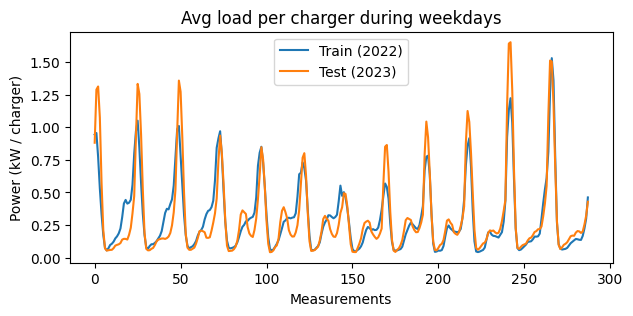

In [57]:
plt.figure(figsize=(7, 3))
plt.plot(data_train.index, data_train['power'], label='Train (2022)')
plt.plot(data_test.index, data_test['power'], label='Test (2023)')
plt.title('Avg load per charger during weekdays')
plt.xlabel('Measurements')
plt.ylabel('Power (kW / charger)')
plt.legend()
plt.show()
#TODO: fix the x-axis to Month-Hour measurement

In [104]:
warnings.filterwarnings("ignore")

# test stationality in time series and if differentiation is required
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()
test_stationality_adf_kpss(combined_data, 0)

# # find p and q for ARIMA
# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)
# plot_acf(combined_data, lags=50, alpha=0.05)
# axs[0].set_title('Autocorrelation original series')

ADF Statistic: -5.551214653219683, p-value: 1.6182245310662238e-06
KPSS Statistic: 0.041472751935483346, p-value: 0.1
stationary = False, differentiation needed = False
